### Spring 2018, CCNY
### BIGDATA Final Project
### Prof: HUY VO
### Student: Mohamed Sondo, Rupesh Basnet

In [ ]:
from collections import defaultdict
from dateutil.parser import parse
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

In [ ]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [ ]:
def read_mta(file_ids):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    filesList = []
    for i in file_ids:
        filesList.append(path + i + ".txt")
    turnstile_list = [pd.read_csv(file) for file in filesList]
    turnstile = pd.concat(turnstile_list)
    turnstile.columns = turnstile.columns.str.strip()
    return turnstile

In [ ]:
# March data
turnstile = read_mta(['170325', '170318', '170311', '170304'])

In [ ]:

# C/A = Control Area (A002)
# UNIT = Remote Unit for a station (R051)
# SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
# DATEn = Represents the date (MM-DD-YY)
# TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
# DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
# ENTRIESn = The comulative entry register value for a device
# EXISTn = The cumulative exit register value for a device
turnstile.columns

In [ ]:
# remove duplicates
turnstile = turnstile[turnstile.DESC != 'RECOVR AUD']
turnstile = turnstile[turnstile.TIME != '04:01:13']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstile
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

In [ ]:
# data is at a turnstile level
turnstile.head()

In [ ]:
turnstile['DATETIME'] = pd.to_datetime(turnstile.DATE + ' ' + turnstile.TIME)

In [ ]:
turnstile = turnstile.set_index(['DATETIME'])
turnstile.head()


### Morning analysis Start

In [ ]:
# filter dataset to 4am to noon
morning = turnstile.between_time('04:00:00', '12:00:00')
morning.head()

In [ ]:

# subtract max from min for each turnstile to get exits
morning_turn = (morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()
#explore outliers
morning_turn['EXITS'].describe()






In [ ]:
# oddly high value for 47-50
morning_turn.loc[morning_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

In [ ]:
morning_turn['EXITS'].sort_values(ascending = True).tail(30)

In [ ]:
# removing values that appear to be counter resets
morning_turn = morning_turn[morning_turn.EXITS <= 11000]

In [ ]:
morning_turn.head()
#morning_turn.shape

In [ ]:
# add up total morning exits per station
morning_station = morning_turn.groupby(['STATION', 'DATE']).sum().reset_index()
morning_station['DATE'] = pd.to_datetime(morning_station['DATE'])
morning_station.head()

In [ ]:
# summing for whole month
morning_month = morning_station.groupby(['STATION'])['EXITS'].sum().reset_index()
morning_month = morning_month.set_index('STATION')

In [ ]:
# determine busiest stations
nrng_topsts = morning_month.sort_values('EXITS', ascending=False).head(15)
nrng_topsts.head()
nrng_topsts.plot(kind='barh', title='Morning Exits by Station')

### Grand Central Station analysis

Station chosen because it has the greatest number of morning exits. What do exit patterns look like over the course of the month (at four hour increments). Weekly patterns?

In [ ]:
# limit to Grand Central at turnstile level
grdcentral = turnstile[turnstile['STATION'] == 'GRD CNTRL-42 ST']

In [ ]:
grdcentral.shape

In [ ]:
grdcentral.head()

In [ ]:
turnstiles = grdcentral['SCP'].unique()

In [ ]:
masked_dfs = []
for i in turnstiles:
    mask = grdcentral[((grdcentral["C/A"] == "R236") & 
    (grdcentral["UNIT"] == "R045") & 
    (grdcentral["SCP"] ==  i) & 
    (grdcentral["STATION"] == "GRD CNTRL-42 ST"))]
            
    mask['DIFFS'] = mask['EXITS'].diff()
    masked_dfs.append(mask)

In [ ]:
exits_turn = pd.concat(masked_dfs)

In [ ]:
exits_turn.head()

In [ ]:
#remove NaN values and negative values (i.e. counter resets)
exits_turn.dropna(inplace=True)
exits_turn = exits_turn[exits_turn['DIFFS'] >= 0]

In [27]:
# now have turnstile exits per four period (diffs column)
exits_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2017-03-03 04:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,04:00:00,REGULAR,5334942,3221500,0.0
2017-03-03 08:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,08:00:00,REGULAR,5334969,3221541,41.0
2017-03-03 12:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,12:00:00,REGULAR,5335160,3221686,145.0
2017-03-03 16:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,16:00:00,REGULAR,5335747,3221811,125.0
2017-03-03 20:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,20:00:00,REGULAR,5337059,3221856,45.0


In [28]:
# add exits across turnstiles by time
exits_turn = exits_turn.reset_index()
ct = exits_turn.groupby(['DATETIME'])['DIFFS'].sum().reset_index()

In [29]:
ct.set_index(['DATETIME'], inplace=True)
ct.head()

,DIFFS
DATETIME,
2017-02-25 04:00:00,25.0
2017-02-25 08:00:00,438.0
2017-02-25 12:00:00,1960.0
2017-02-25 16:00:00,2241.0
2017-02-25 20:00:00,2655.0


In [30]:
we1 = ct[(ct.index > '2017-02-25 00:00:00') & (ct.index < '2017-02-27 05:00:00')]
wd1 = ct[(ct.index > '2017-02-27 00:00:00') & (ct.index < '2017-03-04 05:00:00')]
we2 = ct[(ct.index > '2017-03-04 00:00:00') & (ct.index < '2017-03-06 05:00:00')]
wd2 = ct[(ct.index > '2017-03-06 00:00:00') & (ct.index < '2017-03-11 05:00:00')]
we3 = ct[(ct.index > '2017-03-11 00:00:00') & (ct.index < '2017-03-13 05:00:00')]
wd3 = ct[(ct.index > '2017-03-13 00:00:00') & (ct.index < '2017-03-18 05:00:00')]
we4 = ct[(ct.index > '2017-03-18 00:00:00') & (ct.index < '2017-03-20 05:00:00')]
wd4 = ct[(ct.index > '2017-03-20 00:00:00') & (ct.index < '2017-03-25 05:00:00')]

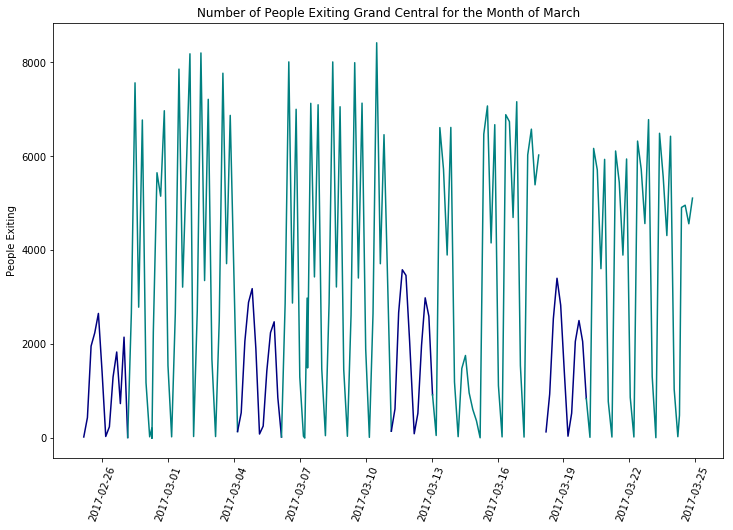

In [31]:
plt.figure(figsize=(12,8))

plt.xticks(rotation=70)
plt.plot(we1, color = 'navy')
plt.plot(wd1, color = '#008080')
plt.plot(we2, color = 'navy')
plt.plot(wd2, color = '#008080')
plt.plot(we3, color = 'navy')
plt.plot(wd3, color = '#008080')
plt.plot(we4, color = 'navy')
plt.plot(wd4, color = '#008080')
plt.title('Number of People Exiting Grand Central for the Month of March')
plt.ylabel('People Exiting')

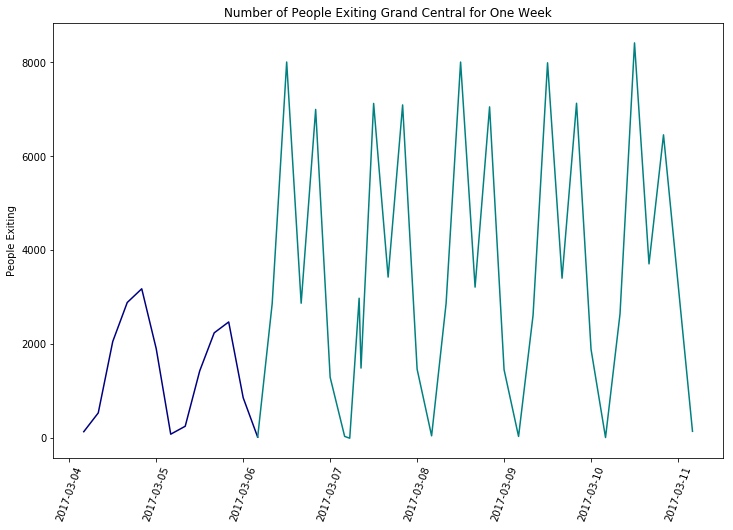

In [32]:
plt.figure(figsize=(12,8))


plt.xticks(rotation=70)
plt.plot(we2, color = 'navy')
plt.plot(wd2, color = '#008080')
plt.title('Number of People Exiting Grand Central for One Week')
plt.ylabel('People Exiting')

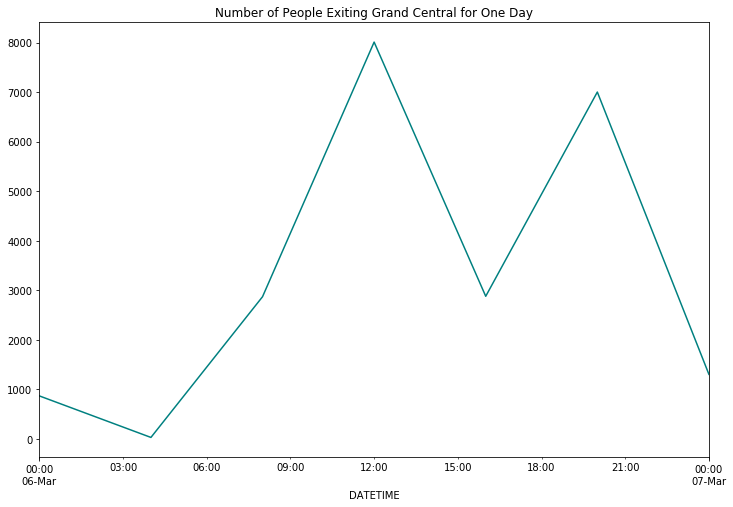

In [33]:
plt.figure(figsize=(12,8))


plt.xticks(rotation=200)
weekday1 = ct[(ct.index > '2017-03-05 21:00:00') & (ct.index < '2017-03-07 03:00:00')]
weekday1['DIFFS'].plot(title = 'Number of People Exiting Grand Central for One Day', color = '#008080' )

### Afternoon analysis Start

In [89]:
# filter dataset noon to 17(5pm)
afternoon = turnstile.between_time('12:00:00', '17:00:00')

afternoon.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,12:00:00,REGULAR,6096165,2066103
2017-03-18 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,16:00:00,REGULAR,6096540,2066168
2017-03-19 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,12:00:00,REGULAR,6097364,2066334
2017-03-19 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,16:00:00,REGULAR,6097633,2066393
2017-03-20 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2017,12:00:00,REGULAR,6098566,2066844


In [90]:
# subtract max from min for each turnstile to get exits
afternoon_turn = (afternoon.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -afternoon.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()
#explore outliers
afternoon_turn['EXITS'].describe()


count    1.306e+05
mean     2.823e+02
std      4.700e+04
min      0.000e+00
25%      0.000e+00
50%      1.600e+01
75%      1.440e+02
max      1.675e+07
Name: EXITS, dtype: float64

In [91]:
# oddly high value for 47-50
afternoon_turn.loc[afternoon_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

60174    683
60185    685
60569    709
60182    712
60184    717
60176    719
60822    765
60178    790
60183    807
60177    890
Name: EXITS, dtype: int64

In [92]:
afternoon_turn['EXITS'].sort_values(ascending = True).tail(30)

35713         1899
62536         1907
69256         1923
35702         1939
32930         1972
104401        1998
32924         2017
32925         2052
32931         2054
104149        2066
35727         2072
101021        2089
            ...   
101101        2330
101088        2702
75664        19465
73716        87311
114855      126685
78251       246287
52632       455895
106034      721364
52853      1386551
48309      1600605
56132      1698095
71633     16746606
Name: EXITS, Length: 30, dtype: int64

In [93]:
# removing values that appear to be counter resets
#afternoon_turn = afternoon_turn[afternoon_turn.EXITS <= 11000]

In [94]:
afternoon_turn.head()
#afternoon_turn.shape

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/25/2017,0
1,A002,R051,02-00-00,59 ST,02/26/2017,0
2,A002,R051,02-00-00,59 ST,02/27/2017,0
3,A002,R051,02-00-00,59 ST,02/28/2017,0
4,A002,R051,02-00-00,59 ST,03/01/2017,0


In [95]:
#add up total afternoon exit per station 
afternoon_station = afternoon_turn.groupby(['STATION', 'DATE']).sum().reset_index()
afternoon_station['DATE'] = pd.to_datetime(afternoon_station['DATE'])
afternoon_station.head()

,STATION,DATE,EXITS
0,1 AV,2017-02-25,0
1,1 AV,2017-02-26,0
2,1 AV,2017-02-27,0
3,1 AV,2017-02-28,0
4,1 AV,2017-03-01,0


In [96]:
# summing for whole month
afternoon_month = afternoon_station.groupby(['STATION'])['EXITS'].sum().reset_index()
afternoon_month = afternoon_month.set_index('STATION')

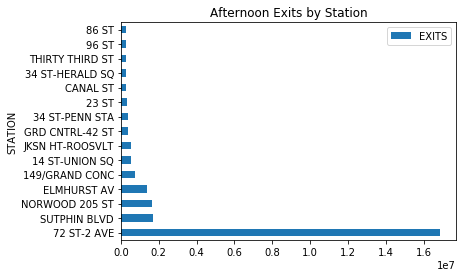

In [97]:
# determine busiest stations
aftn_topsts = afternoon_month.sort_values('EXITS', ascending=False).head(15)
aftn_topsts.head()
aftn_topsts.plot(kind='barh', title='Afternoon Exits by Station')

### 14 Street Union Square analysis
Station chosen because it has the greatest number of afternoon exits. What do exit patterns look like over the course of the month (at four hour increments). Weekly patterns?

In [98]:
# limit to Grand Central at turnstile level
unionsqr14st = turnstile[turnstile['STATION'] == '14 ST-UNION SQ']

In [99]:
unionsqr14st.shape

(6499, 11)

In [100]:
unionsqr14st.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 01:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,01:00:00,REGULAR,1408269,3489681
2017-03-18 05:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,05:00:00,REGULAR,1408280,3489694
2017-03-18 09:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,09:00:00,REGULAR,1408285,3489794
2017-03-18 13:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,13:00:00,REGULAR,1408347,3490356
2017-03-18 17:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,17:00:00,REGULAR,1408608,3491241


In [101]:
 turnstiles1 = unionsqr14st['SCP'].unique()


In [102]:
masked_dfs1 = []
for i in turnstiles1:
    mask1 = unionsqr14st[((unionsqr14st["C/A"] == "A033") & 
    (unionsqr14st["UNIT"] == "R170") & 
    (unionsqr14st["SCP"] ==  i) & 
    (unionsqr14st["STATION"] == "14 ST-UNION SQ"))]
            
    mask1['DIFFS'] = mask['EXITS'].diff()
    masked_dfs1.append(mask1)

/Users/epsilon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
exits_turn1 = pd.concat(masked_dfs1)

In [104]:
exits_turn1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2017-03-18 01:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,01:00:00,REGULAR,1408269,3489681,NaN
2017-03-18 05:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,05:00:00,REGULAR,1408280,3489694,NaN
2017-03-18 09:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,09:00:00,REGULAR,1408285,3489794,NaN
2017-03-18 13:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,13:00:00,REGULAR,1408347,3490356,NaN
2017-03-18 17:00:00,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,03/18/2017,17:00:00,REGULAR,1408608,3491241,NaN


In [105]:
#remove NaN values and negative values (i.e. counter resets)
exits_turn1.dropna(inplace=True)
exits_turn1 = exits_turn1[exits_turn1['DIFFS'] >= 0]

In [106]:
# now have turnstile exits per four period (diffs column)
exits_turn1.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,


In [107]:
# add exits across turnstiles by time
exits_turn1 = exits_turn1.reset_index()
ct1 = exits_turn1.groupby(['DATETIME'])['DIFFS'].sum().reset_index()

In [108]:
ct1.set_index(['DATETIME'], inplace=True)
ct1.head()

,DIFFS
DATETIME,


### Evening analysis Start

In [133]:
# filter dataset  from 17(5pm) to 21(9pm)
evening = turnstile.between_time('17:00:00', '21:00:00')
evening.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,20:00:00,REGULAR,6097011,2066210
2017-03-19 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,20:00:00,REGULAR,6098007,2066441
2017-03-20 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2017,20:00:00,REGULAR,6100226,2066964
2017-03-21 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2017,20:00:00,REGULAR,6102302,2067564
2017-03-22 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/22/2017,20:00:00,REGULAR,6104256,2068175


In [134]:
# subtract max from min for each turnstile to get exits
evening_turn = (evening.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -evening.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()
#explore outliers
evening_turn['EXITS'].describe()


count    1.298e+05
mean     6.123e+01
std      8.008e+03
min      0.000e+00
25%      0.000e+00
50%      0.000e+00
75%      0.000e+00
max      2.885e+06
Name: EXITS, dtype: float64

In [135]:
# oddly high value for 47-50
evening_turn.loc[evening_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

60239     6
60379    10
60099    14
60183    15
60211    18
60127    20
60407    22
60155    29
60071    35
60043    43
Name: EXITS, dtype: int64

In [136]:
evening_turn['EXITS'].sort_values(ascending = True).tail(30)

3259        1973
89511       2007
89520       2047
89514       2096
3267        2106
89183       2106
90743       2111
90751       2116
89519       2122
90745       2135
89175       2166
90750       2188
          ...   
35674       2366
90741       2469
35681       2526
3263        2558
35676       2568
35682       2691
35683       2733
35684       2936
35677       2987
35685       3392
35678       3539
24011    2885026
Name: EXITS, Length: 30, dtype: int64

In [137]:
# removing values that appear to be counter resets
evening_turn = evening_turn[evening_turn.EXITS <= 11000]

In [138]:
evening_turn.head()
#evening_turn.shape()

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/25/2017,0
1,A002,R051,02-00-00,59 ST,02/26/2017,0
2,A002,R051,02-00-00,59 ST,02/27/2017,0
3,A002,R051,02-00-00,59 ST,02/28/2017,0
4,A002,R051,02-00-00,59 ST,03/01/2017,0


In [139]:
# add up total morning exits per station
evening_station = evening_turn.groupby(['STATION', 'DATE']).sum().reset_index()
evening_station['DATE'] = pd.to_datetime(evening_station['DATE'])
evening_station.head()

,STATION,DATE,EXITS
0,1 AV,2017-02-25,0
1,1 AV,2017-02-26,0
2,1 AV,2017-02-27,0
3,1 AV,2017-03-01,0
4,1 AV,2017-03-02,0


In [140]:
# summing for whole month
evening_month = evening_station.groupby(['STATION'])['EXITS'].sum().reset_index()
evening_month = evening_month.set_index('STATION')

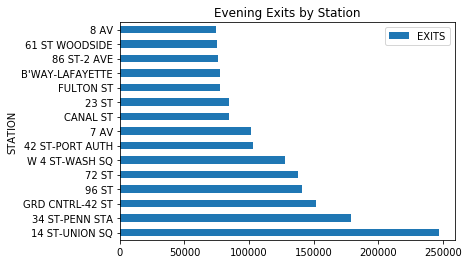

In [141]:
# determine busiest stations
evng_topsts = evening_month.sort_values('EXITS', ascending=False).head(15)
evng_topsts.head()
evng_topsts.plot(kind='barh', title='Evening Exits by Station')

### Night analysis Start

In [142]:
# filter dataset  from 21(9pm) to Midnigt
night = turnstile.between_time('21:00:00', '00:00:00')
night.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,00:00:00,REGULAR,6095917,2065975
2017-03-19,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,00:00:00,REGULAR,6097214,2066234
2017-03-20,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2017,00:00:00,REGULAR,6098249,2066466
2017-03-21,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2017,00:00:00,REGULAR,6100540,2066998
2017-03-22,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/22/2017,00:00:00,REGULAR,6102653,2067599


In [143]:
# subtract max from min for each turnstile to get exits
night_turn = (night.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -night.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()
#explore outliers
night_turn['EXITS'].describe()


count    124635.000
mean          5.826
std          90.189
min           0.000
25%           0.000
50%           0.000
75%           0.000
max        9007.000
Name: EXITS, dtype: float64

In [144]:
#explore outliers
night_turn['EXITS'].describe()

count    124635.000
mean          5.826
std          90.189
min           0.000
25%           0.000
50%           0.000
75%           0.000
max        9007.000
Name: EXITS, dtype: float64

In [145]:
# oddly high value for 47-50
night_turn.loc[night_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

58843    0
58844    0
58845    0
58846    0
58847    0
58848    0
58849    0
58850    0
58822    0
59490    0
Name: EXITS, dtype: int64

In [146]:
night_turn['EXITS'].sort_values(ascending = True).tail(30)

93103    2478
61880    2550
85146    2609
85118    2616
93047    2676
93031    2678
85314    2678
84978    2684
3231     2714
69730    2807
34905    3096
68777    3137
         ... 
3147     3614
93187    4348
68750    4511
93159    4519
93271    4523
34859    4590
93131    4764
68723    4854
68696    5038
35121    5074
34878    5423
34853    9007
Name: EXITS, Length: 30, dtype: int64

In [147]:
# removing values that appear to be counter resets
night_turn = night_turn[night_turn.EXITS <= 11000]

In [148]:
night_turn.head()
#morning_turn.shape

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/25/2017,0
1,A002,R051,02-00-00,59 ST,02/26/2017,0
2,A002,R051,02-00-00,59 ST,02/27/2017,0
3,A002,R051,02-00-00,59 ST,02/28/2017,0
4,A002,R051,02-00-00,59 ST,03/02/2017,0


In [149]:
# add up total night exits per station
night_station = night_turn.groupby(['STATION', 'DATE']).sum().reset_index()
night_station['DATE'] = pd.to_datetime(night_station['DATE'])
night_station.head()

,STATION,DATE,EXITS
0,1 AV,2017-02-25,0
1,1 AV,2017-02-26,0
2,1 AV,2017-02-27,0
3,1 AV,2017-03-01,0
4,1 AV,2017-03-02,0


In [150]:
# summing for whole month
night_month = night_station.groupby(['STATION'])['EXITS'].sum().reset_index()
night_month = night_month.set_index('STATION')

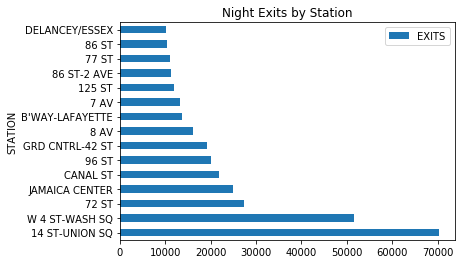

In [151]:
# determine busiest stations
nght_topsts = night_month.sort_values('EXITS', ascending=False).head(15)
nght_topsts.head()
nght_topsts.plot(kind='barh', title='Night Exits by Station')

### 14 Street  Union Square night Station analysis


### Overnight analysis Start

In [152]:
# filter dataset  from  Midnigt to 4 am
overnight = turnstile.between_time('00:00:00', '04:00:00')
overnight.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,00:00:00,REGULAR,6095917,2065975
2017-03-18 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,04:00:00,REGULAR,6095980,2065977
2017-03-19 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,00:00:00,REGULAR,6097214,2066234
2017-03-19 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,04:00:00,REGULAR,6097250,2066240
2017-03-20 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2017,00:00:00,REGULAR,6098249,2066466


In [153]:
# subtract max from min for each turnstile to get exits
overnight_turn = (overnight.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -overnight.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()

In [154]:
#explore outliers
overnight_turn['EXITS'].describe()

count    127392.000
mean          9.730
std         184.801
min           0.000
25%           0.000
50%           0.000
75%           6.000
max       65344.000
Name: EXITS, dtype: float64

In [155]:
# oddly high value for 47-50
overnight_turn.loc[overnight_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

58895    30
58871    31
58920    31
59248    31
58925    31
59383    31
58866    33
58893    36
59244    38
59384    41
Name: EXITS, dtype: int64

In [156]:
overnight_turn['EXITS'].sort_values(ascending = True).tail(30)

89957       370
89951       379
89033       379
114510      379
108300      380
51400       383
89956       385
108328      389
90068       397
114347      397
89955       398
51398       403
          ...  
89060       432
90070       439
28043       452
20772       458
114509      476
20771       489
88976       494
123445      520
89005       608
89032       627
89004       882
73125     65344
Name: EXITS, Length: 30, dtype: int64

In [157]:
# removing values that appear to be counter resets
overnight_turn = overnight_turn[overnight_turn.EXITS <= 11000]

In [158]:
overnight_turn.head()
#overnight_turn.shape

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/25/2017,0
1,A002,R051,02-00-00,59 ST,02/26/2017,0
2,A002,R051,02-00-00,59 ST,02/27/2017,0
3,A002,R051,02-00-00,59 ST,02/28/2017,0
4,A002,R051,02-00-00,59 ST,03/01/2017,0


In [159]:
# add up total morning exits per station
overnight_station = overnight_turn.groupby(['STATION', 'DATE']).sum().reset_index()
overnight_station['DATE'] = pd.to_datetime(overnight_station['DATE'])
overnight_station.head()

,STATION,DATE,EXITS
0,1 AV,2017-02-25,0
1,1 AV,2017-02-26,0
2,1 AV,2017-02-27,0
3,1 AV,2017-02-28,0
4,1 AV,2017-03-01,0


In [160]:
# summing for whole month
overnight_month = overnight_station.groupby(['STATION'])['EXITS'].sum().reset_index()
overnight_month = overnight_month.set_index('STATION')

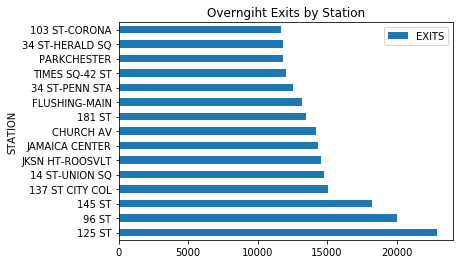

In [161]:
# determine busiest stations
ovrnght_topsts = overnight_month.sort_values('EXITS', ascending=False).head(15)
ovrnght_topsts.head()
ovrnght_topsts.plot(kind='barh', title='Overngiht Exits by Station')

### 125 Street  overnight Station analysis
